# **Project : Predicting the crisis of Covid-19 during April-May,2021 by using ODE and Bisection**

### Charita Ampharpai  , Id : 6681357

#### **Use ODE to find infection rate**

**Compute Active Case:**


$$ \text{Active} = \text{Confirmed} - (\text{Deaths} + \text{Recovered}) $$

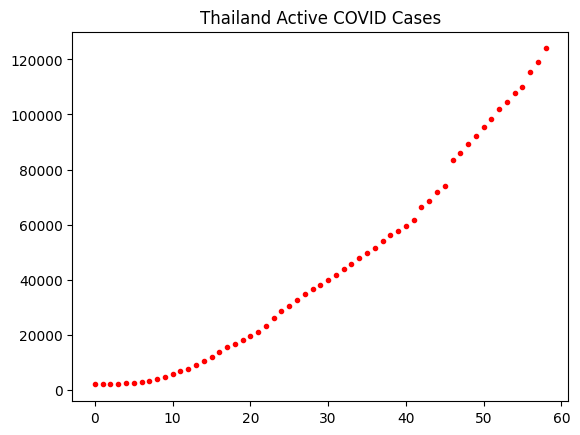

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('/Users/creamy/Desktop/archive (1)/covid_19_data.csv')

thailand = df[df['Country/Region'] == 'Thailand'].copy() 

thailand['ObservationDate'] = pd.to_datetime(thailand['ObservationDate'])
start_date = pd.to_datetime('2021-04-1')
end_date = pd.to_datetime('2021-05-29')
mask = (thailand['ObservationDate'] >= start_date) & (thailand['ObservationDate'] <= end_date)
thailand = thailand.loc[mask]

thailand['Active'] = thailand['Confirmed'] - thailand['Deaths'] - thailand['Recovered'] 


plt.plot(thailand['Active'].values, 'r.')
plt.title("Thailand Active COVID Cases")
plt.show()

* **Population in Thailand,2021 ($N$):** $\approx 70,000,000$.
* **Recovery Rate ($\gamma$):** Based on the public health, the infectious period is approximately **8 days**.
    $$\gamma = \frac{1}{\text{recovery days}} = \frac{1}{8} = 0.125$$
*  $R_t$ 
$$R_t = \frac{\beta}{\gamma}$$

* $R_0$ = 5.08
* $\beta$ = 5.08 * 0.125 = 0.635

In [ ]:
start, end = '2021-04-01', '2021-05-29'
mask = (thailand['ObservationDate'] >= start) & (thailand['ObservationDate'] <= end)
my_data = thailand.loc[mask]
real_active = (my_data['Confirmed'] - my_data['Deaths'] - my_data['Recovered']).values
days = np.arange(len(real_active))

N = 70000000  
recovery_day = 8
gamma = 1 / recovery_day  
sick_covid = real_active[0]  
healthy_people = N - real_active 


* Let $\beta$ be the infection rate (How fast the virus will spread to another person). Use the Least Square Error (SSE), calculated the error between the  predicted blue line and the real red dots. By start from 0.10 until 0.70 because the predicted beta from R0 ( From scientific that virus can spread is 5.08 * gamma = 0.635). It gives beta = 0.20 to find the Rt = 0.20 / 0.125 = 1.6 which means that 1 person who got COVID could spread it to 1.6 other people
 **Error Calculation:** Compares the simulation against real data using Sum of Squared Errors (SSE).
    $$E(\beta) = \sum (I_{\text{real}} - I_{\text{model}})^2$$

* $I_{\text{real}}$ = number of infected people on each day ( actual data)
* $I_{\text{model}}$ = number of infected people on the prediction day


**Use ODE Formula (Euler's Method) :**
* Sick people: $\frac{dH}{dt} = -\frac{\beta H C}{N}$ : decreasing (new covid people)
* Recovered people : $\frac{dR}{dt} = \gamma * C $ : Increasing (Already Recovered)
* Population for each day : $\frac{dC}{dt} = \frac{\beta H C}{N} - \gamma R$
```python
    
    new_sick      = (test_beta * H * C) / N
    new_recovered = gamma * C
    
Check for the new patient:

    H = H - new_sick                 
    C = C + new_sick - new_recovered 
    R = R + new_recovered            

H = Healthy People  
C = Covid Patients 
R = Recovered People 




In [ ]:
possible_betas = np.arange(0.10, 0.70, 0.01) # start from beta = 0.1 from Rt = 0.8(min), stop at beta = 0.51 from Rt = 5 (max), jump to 0.01

best_beta = 0 
lowest_error = float('inf')  # Find the least error by compare with each one but it never get reached to infinity
best_prediction = []  # Check the best prediction (Blue line)


Rt = 1.6
Beta = 0.2


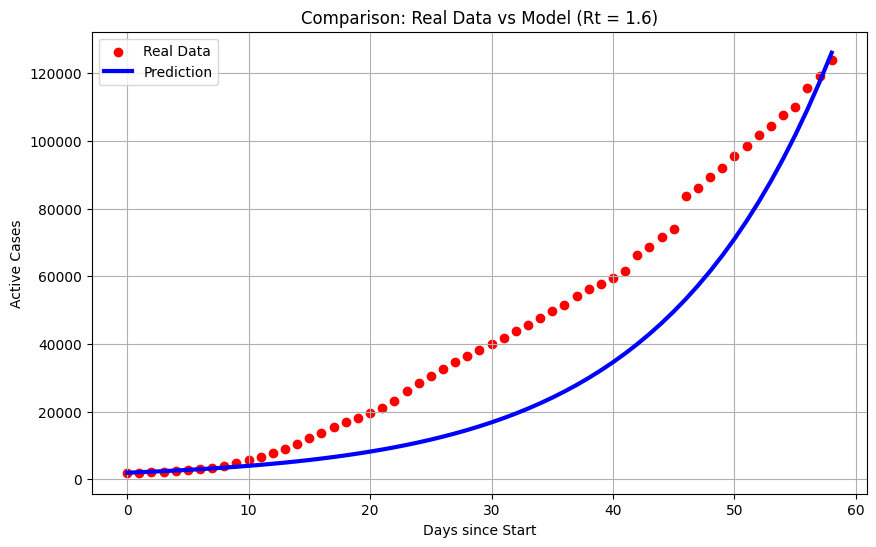

In [ ]:
for test_beta in possible_betas:
    H, C, R = healthy_people[0], sick_covid, 0
    current_prediction = [] # see for the next day

    for day in days: # Check for each days in the dataset
        current_prediction.append(C) #check for the new covid people
        
        # ODE 
        new_sick      = (test_beta * H * C) / N
        new_recovered = gamma * C
        
        # Chwck for next day
        H = H - new_sick # check healthy people - covid people
        C = C + new_sick - new_recovered # people who already got covid + new covid people - recovered people
        R = R + new_recovered # people who already recovered + new recovered people

    # Compute SSE (The Error)
    total_error = 0 
    for i in range(len(days)): 
        real_val = real_active[i] # sick people start from day 0 (Red dot)
        pred_val = current_prediction[i] # check for the new covid people (Blue line)
        diff = real_val - pred_val # find the mistake between real data and prediction data
        total_error = total_error + (diff * diff) # square the mistake to make it positive , compute the total mistake 

    # SSE
    if total_error < lowest_error: # Find the least error
        lowest_error = total_error 
        best_beta = test_beta 
        best_prediction = current_prediction # save the best prediction graph (Blue line)

Rt = best_beta / gamma
simple_Rt = round(Rt, 2)       
simple_beta = round(best_beta, 2) 

print("Rt =", simple_Rt)
print("Beta =", simple_beta)

plt.figure(figsize=(10,6))
plt.scatter(days, real_active, color='red', label='Real Data')
plt.plot(days, best_prediction, color='blue', linewidth=3, label='Prediction')

plt.title("Comparison: Real Data vs Model (Rt = " + str(simple_Rt) + ")")
plt.xlabel("Days since Start")
plt.ylabel("Active Cases")
plt.legend()
plt.grid(True)
plt.show()


####  **Predicting the Crisis by Bisection**

Assume that there are 20,000 beds.
* Check the number of sick people on each day.<br>
* Let dt = 0.1, to check for the accurate day.

In [ ]:
amount_hospital = 20000 

def infected_people(target_day) -> int: # target day = mid day : check the number of sick people on each day
    H, C, R = healthy_people[0], sick_covid, 0
    
    current_day = 0
    dt = 0.1 # to check for the accurate day

    while current_day < target_day: # check until the target day
        new_sick      = (best_beta * H * C) / N * dt 
        new_recovered = gamma * C * dt
        
        H = H - new_sick
        C = C + new_sick - new_recovered
        R = R + new_recovered
        
        current_day += dt 
        
    return C

* Low_day = The first April, 2021 (Floor)
* High_day = Last day of May , 2021 (Ceiling)
* Tol = 0.01 : To check for the accuracy
* Crisis day = -1 : To make sure it is a positive number of day
* If sick people > hospitals, then there are many sick people.
* If sick people < hospitals, then the hospitals might be fulled later.


In [ ]:
low_day = 0.0 # The first April (Floor)
high_day = len(days) # May (Ceiling)
tolerance = 0.01 # check for the accurate  
crisis_day = -1 

while (high_day - low_day) > tolerance: # Loop until withinn 0.01
    
    mid_day = (low_day + high_day) / 2 

    sick_people = infected_people(mid_day) # sick people from the day above

    if sick_people > amount_hospital: 
        high_day = mid_day # Many sick people
    else:
        low_day = mid_day # Not full yet might happen later

crisis_day = (low_day + high_day) / 2 # calculate the average between the low and high day that is very small differnce

simple_day = round(crisis_day, 2)

Hospitals will be full on: Day 31.3
Hospitals will be full on: 2021-05-02


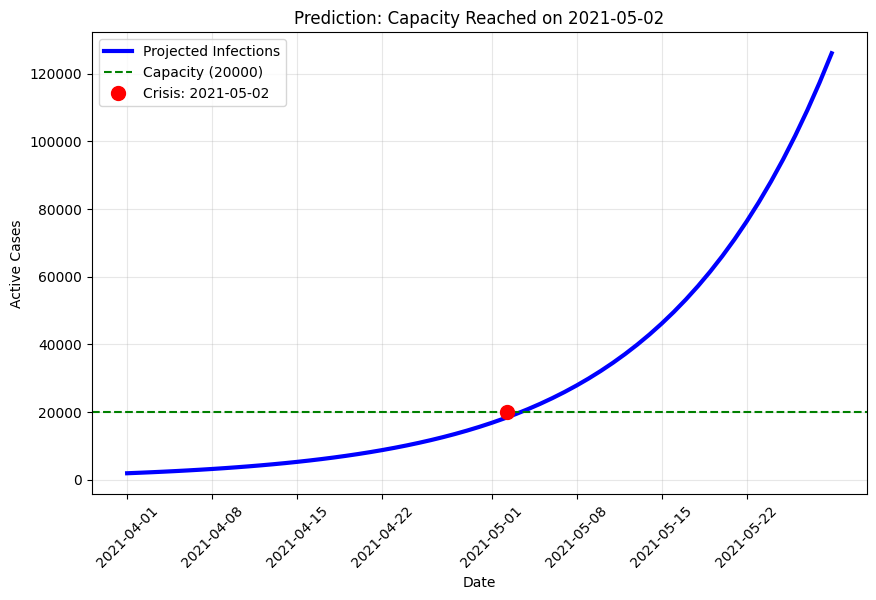

In [60]:
print("Hospitals will be full on: Day", simple_day)

date_list = pd.date_range(start='2021-04-01', periods=len(days))

from datetime import timedelta

crisis_date = pd.to_datetime('2021-04-01') + timedelta(days=crisis_day)

date_list = pd.date_range(start='2021-04-01', periods=len(days))

crisis_date = pd.to_datetime('2021-04-01') + timedelta(days=crisis_day)

date_text = str(crisis_date.date()) 

print("Hospitals will be full on:", date_text)

plt.figure(figsize=(10,6))

plt.plot(date_list, best_prediction, color='blue', linewidth=3, label='Projected Infections')

plt.axhline(y=amount_hospital, color='green', linestyle='--', label="Capacity (" + str(amount_hospital) + ")")

plt.plot(crisis_date, amount_hospital, 'ro', markersize=10, label="Crisis: " + date_text)

plt.title("Prediction: Capacity Reached on " + date_text)
plt.xlabel("Date")
plt.ylabel("Active Cases")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45) 
plt.show()

**References** <br>
Data : https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset <br>
Recovery day for covid : https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/guidance-documents/signs-symptoms-severity.html <br>
Scientific $R_0$ : https://www.researchgate.net/publication/353790276_The_reproductive_number_of_the_Delta_variant_of_SARS-CoV-2_is_far_higher_compared_to_the_ancestral_SARS-CoV-2_virus#:~:text=An%20Rof%205.08%20is,to%20other%20viral%20infections%20such

